# <font color='#F27457'> Text Emotion Detection

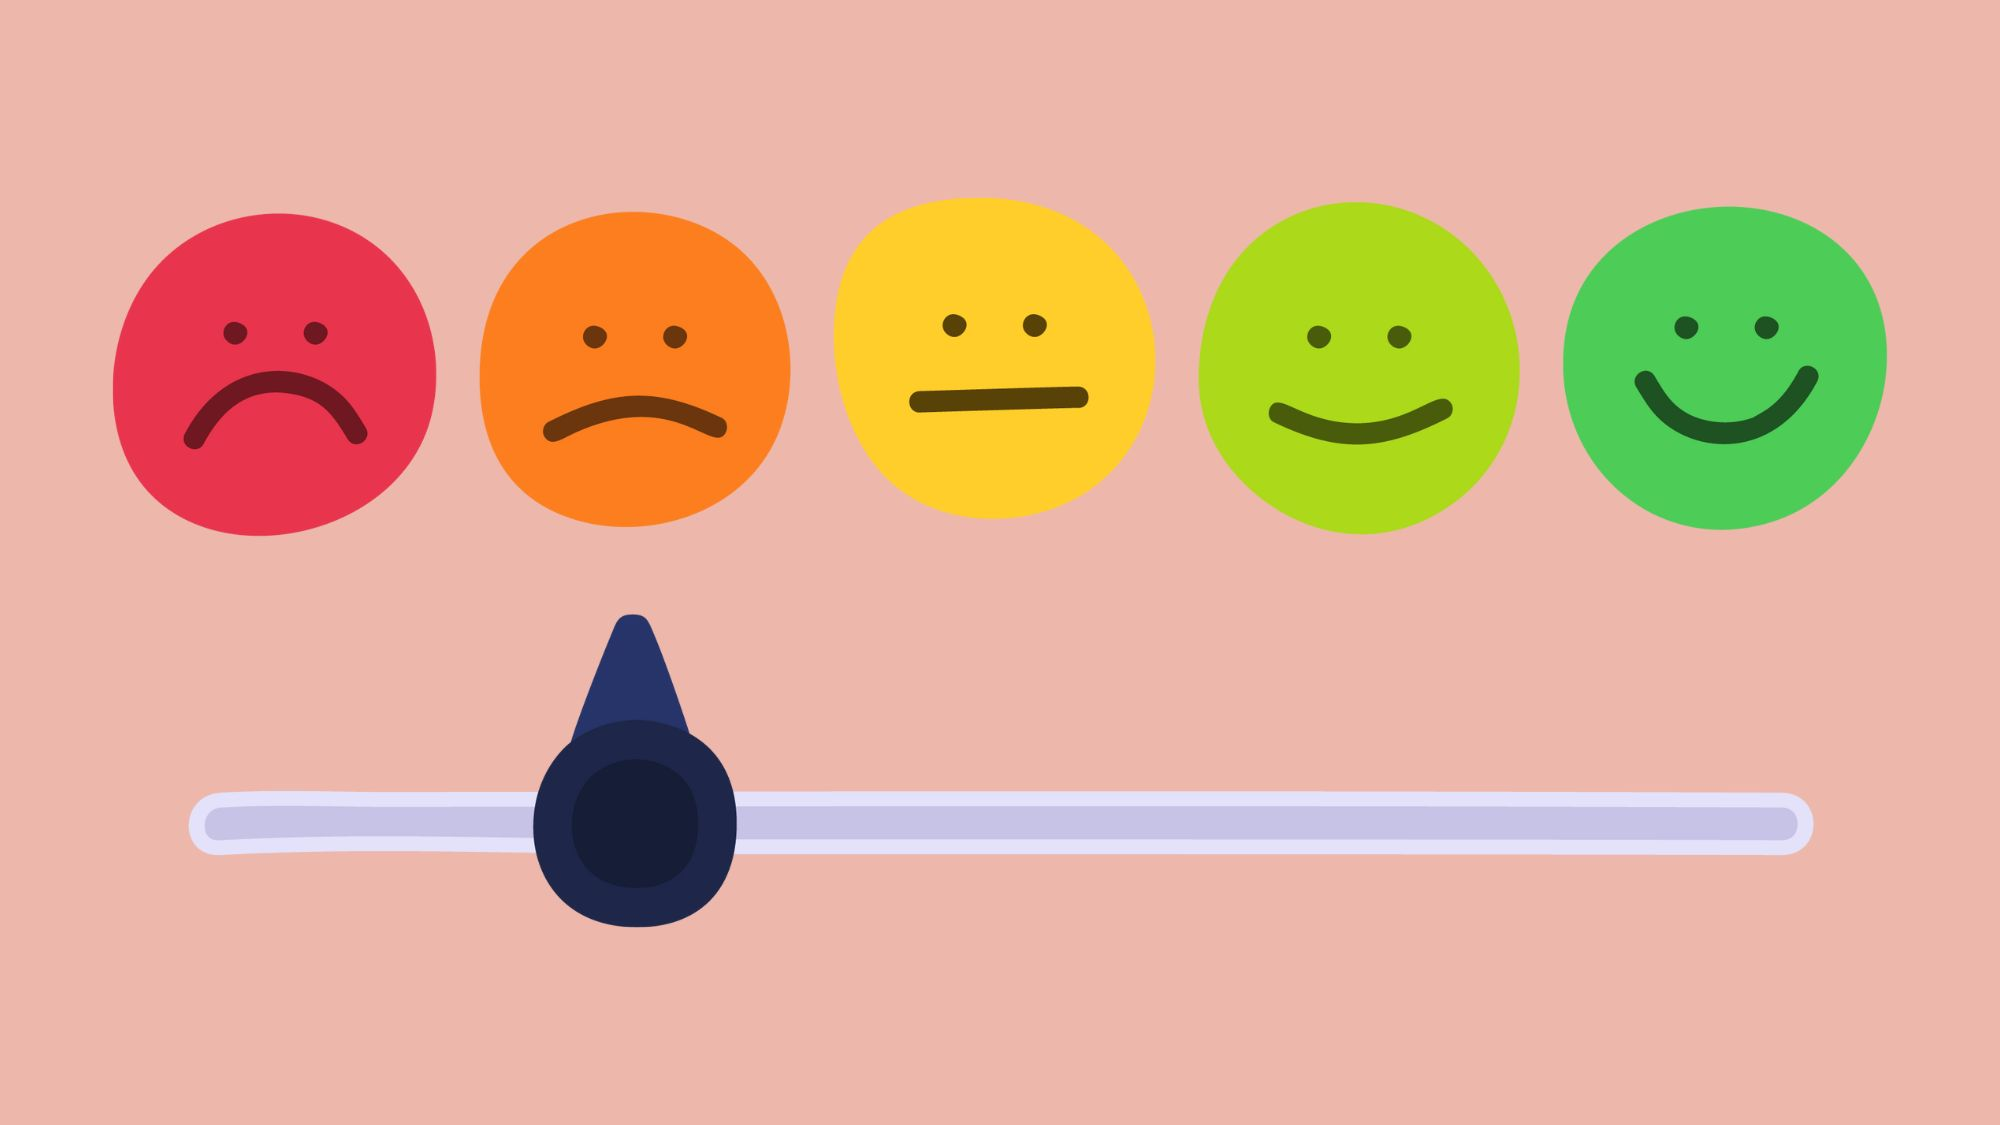

## <font color='#F27457'>Aim
The goal of this project is to predict the emotion expressed in a given piece of text. Given that emotions are often conveyed through personal experiences, the project focuses on analyzing the content of text data to identify and classify the underlying emotion. By leveraging natural language processing (NLP) techniques and machine learning models, the aim is to build a system capable of automatically categorizing text into different emotional states.

## <font color='#F27457'>Dataset Explanation
The dataset used in this project consists of two columns: **Label** and **Text**.

1. **Label**: This column represents the emotion associated with the text. The emotion is encoded as a **one-hot vector**, where each vector contains binary values. Each position in the vector corresponds to a specific emotion, and a value of "1" indicates the presence of that emotion in the text, while "0" means it is not present. 

    - The vector could look something like `1. 0. 0. 0. 0. 0. 0.`, where the "1" in the first position could represent, for example, **love** as the predicted emotion.
    - Each text corresponds to one emotion, and this vector format allows the model to distinguish between different emotions.

2. **Text**: This column contains sentences or short passages that describe emotional experiences. The emotions could range from love, happiness, sadness, anger, surprise, etc. Each piece of text is labeled according to the emotion it expresses.


## <font color='#F27457'>Objective
Using this dataset, the project will involve preprocessing the text, applying feature extraction methods (like TF-IDF or word embeddings), and training a machine learning model (such as Logistic Regression, Random Forest, or Deep Learning models) to predict the emotion (label) for new, unseen text.

## <font color='#F27457'> Requirements

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',None)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import nltk
nltk.download("stopwords")
import re
from nltk.corpus import stopwords
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MONSTER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## <font color='#F27457'> Import Data

In [166]:
df=[]
with open("text.txt", "r") as file:
    for line in file:
        line=line.strip()
        label=' '.join(line[1:line.find("]")].strip().split())
        text=line[line.find("]")+1:].strip()
        df.append([label,text])
df=pd.DataFrame(df,columns=['Label','Text'])

## <font color='#F27457'> EDA (Exploratory Data Analysis)

In [168]:
df.head()

,Label,Text
0,1. 0. 0. 0. 0. 0. 0.,"During the period of falling in love, each tim..."
1,0. 1. 0. 0. 0. 0. 0.,When I was involved in a traffic accident.
2,0. 0. 1. 0. 0. 0. 0.,When I was driving home after several days of...
3,0. 0. 0. 1. 0. 0. 0.,When I lost the person who meant the most to me.
4,0. 0. 0. 0. 1. 0. 0.,The time I knocked a deer down - the sight of ...


In [169]:
df.shape

(7480, 2)

In [170]:
df.isnull().sum()

Label    0
Text     0
dtype: int64

In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7480 entries, 0 to 7479
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   7480 non-null   object
 1   Text    7480 non-null   object
dtypes: object(2)
memory usage: 117.0+ KB


In [172]:
df['Label'].value_counts()

Label
1. 0. 0. 0. 0. 0. 0.    1084
0. 0. 1. 0. 0. 0. 0.    1080
0. 0. 0. 1. 0. 0. 0.    1079
0. 1. 0. 0. 0. 0. 0.    1078
0. 0. 0. 0. 1. 0. 0.    1057
0. 0. 0. 0. 0. 0. 1.    1057
0. 0. 0. 0. 0. 1. 0.    1045
Name: count, dtype: int64

## <font color='#F27457'> Feature Engineering

In [181]:
emotions={'1. 0. 0. 0. 0. 0. 0.':'joy',
          '0. 1. 0. 0. 0. 0. 0.':'fear',
          '0. 0. 1. 0. 0. 0. 0.':'anger',
          '0. 0. 0. 1. 0. 0. 0.':'sadness',
          '0. 0. 0. 0. 1. 0. 0.':'disgust',
          '0. 0. 0. 0. 0. 1. 0.':'shame',
          '0. 0. 0. 0. 0. 0. 1.':'guilt'}
df['Label']=df['Label'].map(emotions)

In [183]:
df['Label'].value_counts()

Label
joy        1084
anger      1080
sadness    1079
fear       1078
disgust    1057
guilt      1057
shame      1045
Name: count, dtype: int64

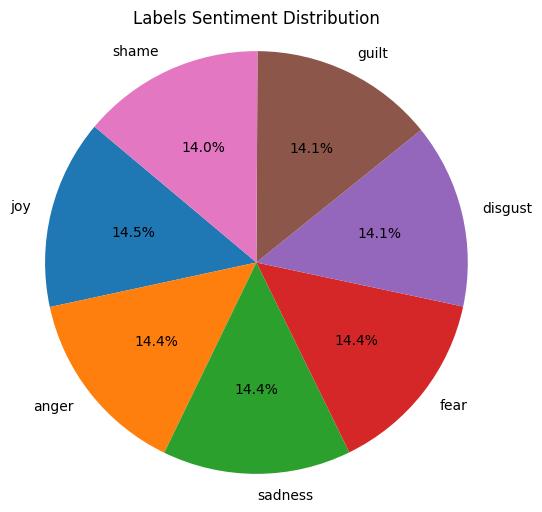

In [269]:

label_counts = df['Label'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    label_counts, 
    labels=label_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
)
plt.title('Labels Sentiment Distribution')
plt.axis('equal')  
plt.show()

## <font color='#F27457'> Preprocess Text

In [97]:
stemmer=nltk.SnowballStemmer("english")
stopword=set(stopwords.words("english"))
def clean_text(text_column):
    # Convert to lowercase
    df[text_column] = df[text_column].str.lower()
    
    # Remove unwanted characters
    df[text_column] = df[text_column].str.replace('[^\w\s]', '', regex=True)
    df[text_column] = df[text_column].str.replace('\w*\d\w*', '', regex=True)
    df[text_column] = df[text_column].str.replace('\n', '', regex=True)
    df[text_column] = df[text_column].str.replace('\r', '', regex=True)
    df[text_column] = df[text_column].str.replace('https?://\S+|www\.\S+', '', regex=True)
    df[text_column] = df[text_column].str.replace('<.*?>+', '', regex=True)
    df[text_column] = df[text_column].str.replace('\[.*?\]', '', regex=True)
    
    # Remove stopwords and apply stemming
    df[text_column] = df[text_column].apply(lambda x: ' '.join(
        stemmer.stem(word) 
        for word in x.split() 
        if word not in stopword
    ))
    return df[text_column]

In [99]:
df.iloc[0]["Text"]

'During the period of falling in love, each time that we met and especially when we had not met for a long time.'

In [101]:
df["Text"]=clean_text("Text")

In [102]:
df.iloc[0]["Text"]

'period fall love time met especi met long time'

## <font color='#F27457'> Word Cloud

In [106]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
from PIL import Image
def wc(data,color):
    plt.figure(figsize=(10,10))
   # mask=np.array(Image.open('cloud.png'))
    wc=WordCloud(background_color=color,stopwords=STOPWORDS)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

### <font color='#F27457'> Word Cloud for Joy

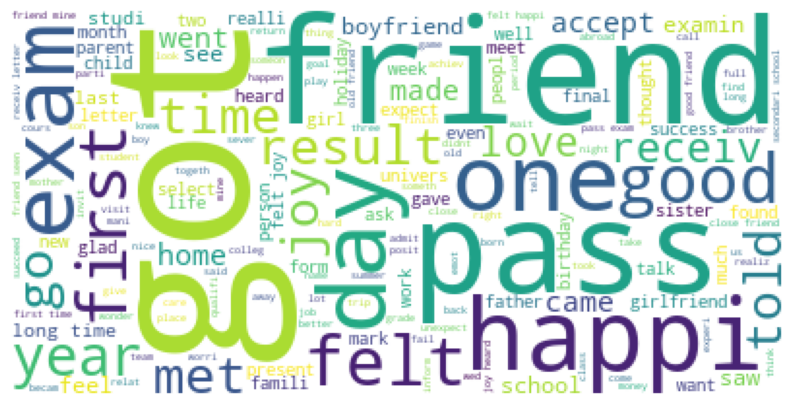

In [109]:
wc(df[df["Label"]=='joy']["Text"],"white")

### <font color='#F27457'> Word Cloud for Fear

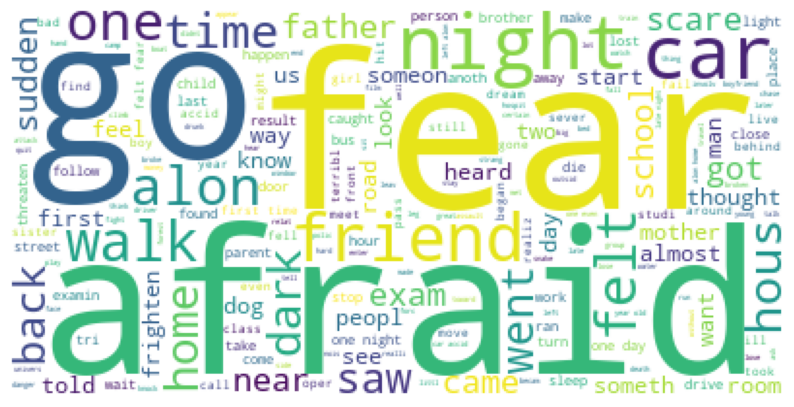

In [113]:
wc(df[df["Label"]=='fear']["Text"],"white")

### <font color='#F27457'> Word Cloud for Anger

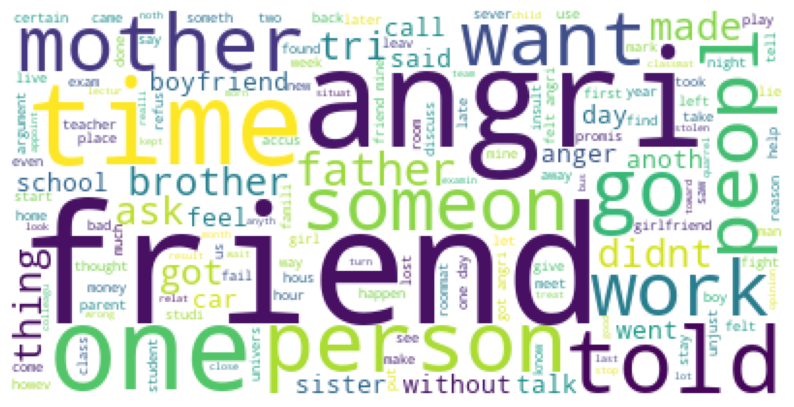

In [116]:
wc(df[df["Label"]=='anger']["Text"],"white")

### <font color='#F27457'> Word Cloud for Sadness

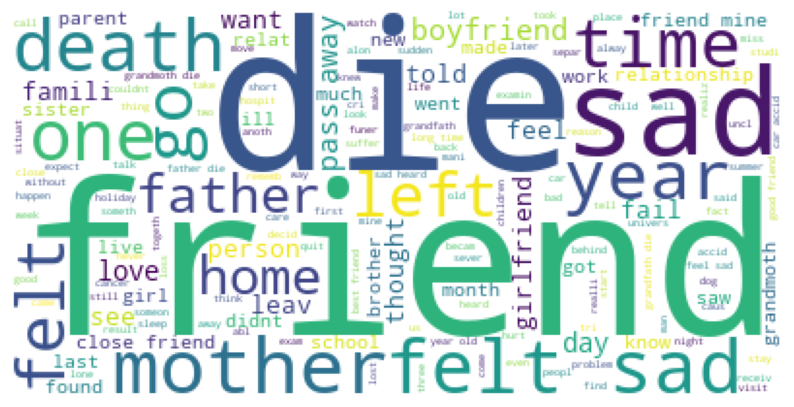

In [121]:
wc(df[df["Label"]=='sadness']["Text"],"white")

### <font color='#F27457'> Word Cloud for Disgust

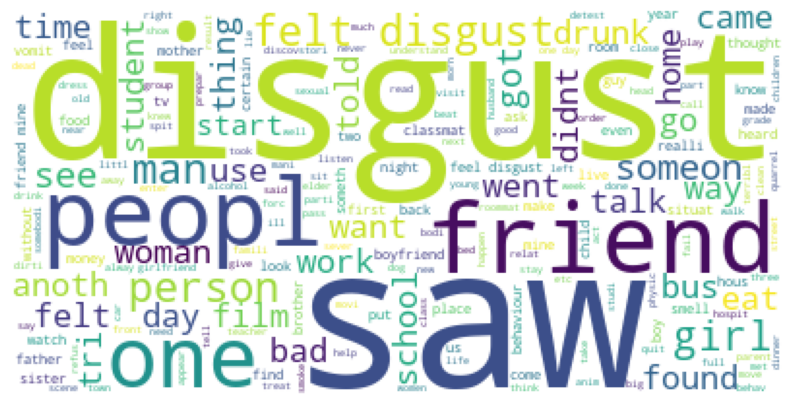

In [125]:
wc(df[df["Label"]=='disgust']["Text"],"white")

### <font color='#F27457'> Word Cloud for Shame

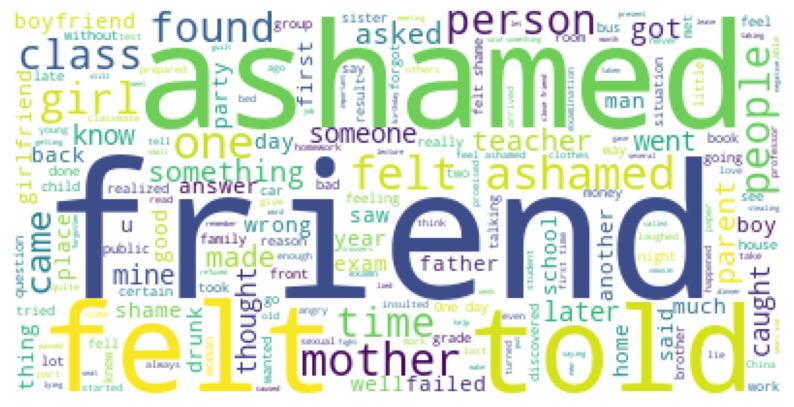

In [185]:
wc(df[df["Label"]=='shame']["Text"],"white")

### <font color='#F27457'> Word Cloud for Guilt

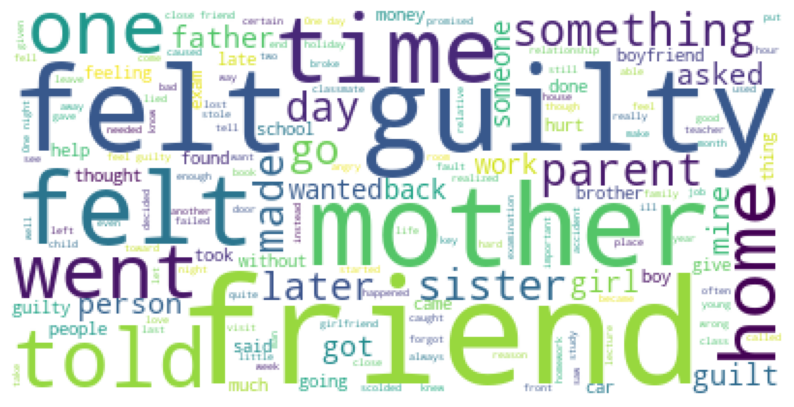

In [192]:
wc(df[df["Label"]=='guilt']["Text"],"white")

## <font color='#F27457'> The Most Used Words

In [196]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(texts, ngram_range=(2, 3), top_n=10):
    vect = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    dtm = vect.fit_transform(texts)
    ngram_counts = dtm.sum(axis=0)
    ngrams_freq = [(word, ngram_counts[0, idx]) for word, idx in vect.vocabulary_.items()]
    return sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:top_n]

### <font color='#F27457'> The Most Used Words for Joy

In [206]:
text = df[df['Label'] == 'joy']['Text']
ngrams = get_top_ngrams(text, ngram_range=(2, 2), top_n=20)
ngrams

[('long time', 38),
 ('felt joy', 21),
 ('felt happy', 19),
 ('secondary school', 17),
 ('passed exam', 16),
 ('close friend', 13),
 ('received letter', 12),
 ('seen long', 10),
 ('passed exams', 10),
 ('old friend', 10),
 ('good friend', 10),
 ('best friend', 10),
 ('heard passed', 10),
 ('gave birth', 9),
 ('entrance exam', 9),
 ('came home', 9),
 ('friend told', 9),
 ('final examination', 9),
 ('admitted university', 9),
 ('university entrance', 9)]

### <font color='#F27457'> The Most Used Words for Fear

In [208]:
text = df[df['Label'] == 'fear']['Text']
ngrams = get_top_ngrams(text, ngram_range=(2, 2), top_n=20)
ngrams

[('did know', 24),
 ('felt fear', 21),
 ('late night', 16),
 ('car accident', 16),
 ('didn know', 12),
 ('middle night', 11),
 ('went home', 11),
 ('years old', 11),
 ('came home', 8),
 ('home late', 8),
 ('going home', 7),
 ('home night', 7),
 ('felt afraid', 7),
 ('years ago', 7),
 ('horror film', 7),
 ('year old', 6),
 ('car driving', 6),
 ('long time', 6),
 ('dark night', 6),
 ('walking home', 6)]

### <font color='#F27457'> The Most Used Words for Anger

In [211]:
text = df[df['Label'] == 'anger']['Text']
ngrams = get_top_ngrams(text, ngram_range=(2, 2), top_n=20)
ngrams

[('got angry', 24),
 ('felt angry', 24),
 ('felt anger', 17),
 ('best friend', 11),
 ('close friend', 11),
 ('did want', 10),
 ('good friend', 10),
 ('friend told', 10),
 ('secondary school', 10),
 ('angry friend', 8),
 ('friend promised', 8),
 ('really angry', 8),
 ('room mate', 8),
 ('class leader', 8),
 ('football match', 7),
 ('accused having', 7),
 ('came home', 7),
 ('promised come', 7),
 ('did pay', 7),
 ('long time', 6)]

### <font color='#F27457'> The Most Used Words for Sadness

In [219]:
text = df[df['Label'] == 'sadness']['Text']
ngrams = get_top_ngrams(text, ngram_range=(2, 2), top_n=20)
ngrams

[('felt sad', 68),
 ('passed away', 54),
 ('close friend', 35),
 ('grandmother died', 29),
 ('grandfather died', 23),
 ('long time', 21),
 ('friend died', 16),
 ('best friend', 16),
 ('years old', 16),
 ('father died', 16),
 ('car accident', 16),
 ('good friend', 13),
 ('close relative', 12),
 ('sad heard', 12),
 ('years ago', 11),
 ('feel sad', 10),
 ('heard death', 10),
 ('left home', 9),
 ('father passed', 9),
 ('died cancer', 8)]

### <font color='#F27457'> The Most Used Words for Disgust

In [217]:
text = df[df['Label'] == 'disgust']['Text']
ngrams = get_top_ngrams(text, ngram_range=(2, 2), top_n=20)
ngrams

[('felt disgusted', 45),
 ('felt disgust', 28),
 ('feel disgusted', 14),
 ('feel disgust', 11),
 ('drunk man', 11),
 ('years old', 8),
 ('long time', 8),
 ('saw people', 7),
 ('saw film', 7),
 ('best friend', 6),
 ('did like', 6),
 ('old man', 6),
 ('really disgusted', 6),
 ('young man', 6),
 ('did want', 6),
 ('close friend', 6),
 ('dining hall', 6),
 ('english lectures', 6),
 ('class leader', 6),
 ('read newspaper', 5)]

### <font color='#F27457'> The Most Used Words for Shame

In [223]:
text = df[df['Label'] == 'shame']['Text']
ngrams = get_top_ngrams(text, ngram_range=(2, 2), top_n=20)
ngrams

[('felt ashamed', 89),
 ('felt shame', 24),
 ('feel ashamed', 18),
 ('did know', 13),
 ('ashamed having', 12),
 ('years old', 11),
 ('close friend', 9),
 ('teacher asked', 8),
 ('asked question', 8),
 ('primary school', 7),
 ('really felt', 7),
 ('class mates', 6),
 ('class teacher', 6),
 ('failing examn', 6),
 ('good friend', 5),
 ('told friend', 5),
 ('long time', 5),
 ('sexual intercourse', 5),
 ('caught stealing', 5),
 ('felt quite', 5)]

### <font color='#F27457'> The Most Used Words for Guilt

In [226]:
text = df[df['Label'] == 'guilt']['Text']
ngrams = get_top_ngrams(text, ngram_range=(2, 2), top_n=20)
ngrams

[('felt guilty', 139),
 ('feel guilty', 29),
 ('close friend', 13),
 ('years old', 10),
 ('long time', 9),
 ('secondary school', 9),
 ('little brother', 8),
 ('felt guilt', 8),
 ('sense guilt', 7),
 ('got angry', 7),
 ('feeling guilt', 7),
 ('ex boyfriend', 7),
 ('came home', 6),
 ('good friend', 6),
 ('started crying', 6),
 ('felt bad', 6),
 ('mother told', 6),
 ('best friend', 6),
 ('guilty having', 6),
 ('later felt', 6)]

## <font color='#F27457'> Modelling

In [236]:
x=df['Text']
y=df['Label']

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier  
from sklearn.naive_bayes import MultinomialNB    


def classification_test(x,y,vect,confusion_mtr=False):
    b=BernoulliNB()
    l=LogisticRegression()
    d=DecisionTreeClassifier()
    rf=RandomForestClassifier()
    h=GradientBoostingClassifier()
    a=AdaBoostClassifier()
    m=MultinomialNB()
    algos=[b,l,d,rf,h,a,b]

    algo_names=['Bernoulli NB','Logistic Regression','Decision Tree Classifier','Random Forest Classifier','Gradient Boosting Classifier','Ada Boost Classifier','Multinomial NB']

    accuracy=[]
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

    result=pd.DataFrame(columns=['Accuracy Score'],index=algo_names)

    for i, algo in enumerate(algos):
        x_train_dtm = vect.fit_transform(x_train)
        x_test_dtm = vect.transform(x_test)

        if hasattr(algo, 'fit'):
            x_train_dtm = x_train_dtm  
            x_test_dtm = x_test_dtm   

        p = algo.fit(x_train_dtm, y_train).predict(x_test_dtm)
        accuracy.append(accuracy_score(y_test, p))
        if confusion_mtr:
            cm = confusion_matrix(y_test, p)
            plt.figure(figsize=(5, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=algo.classes_, yticklabels=algo.classes_,cbar=None)
            plt.title(f"Confusion Matrix - {algo_names[i]}")
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.show()

    result['Accuracy Score']=accuracy

    r_table=result.sort_values('Accuracy Score',ascending=False)
    
        
        
    return r_table[['Accuracy Score']]
    

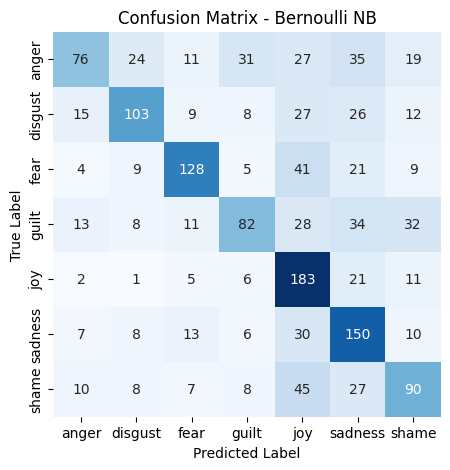

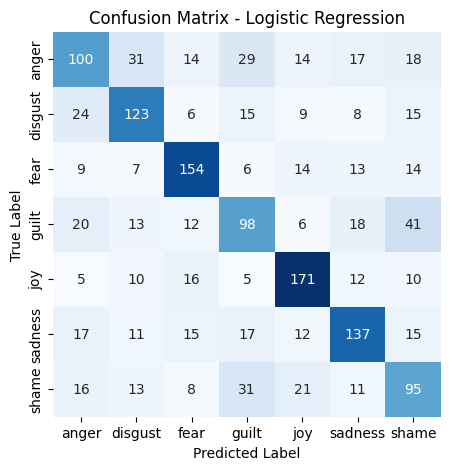

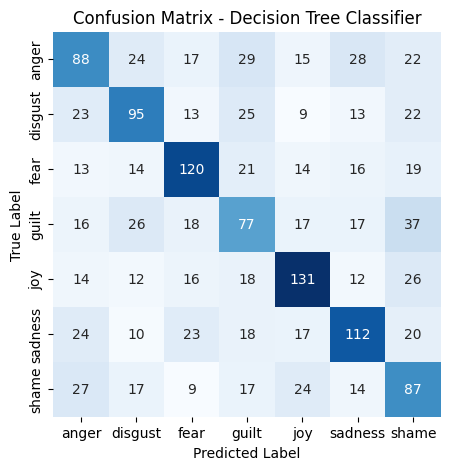

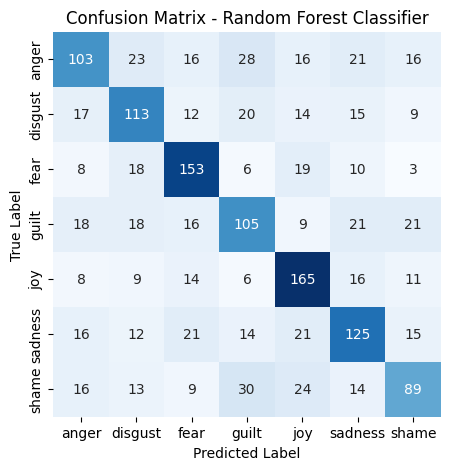

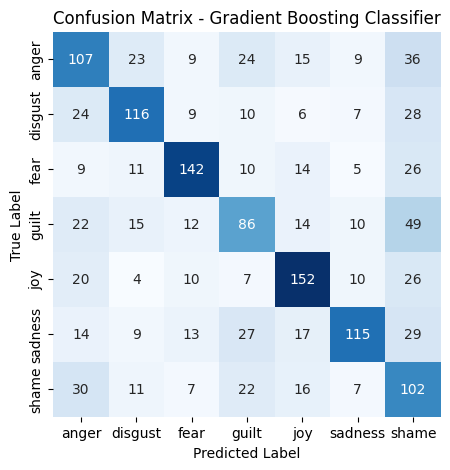

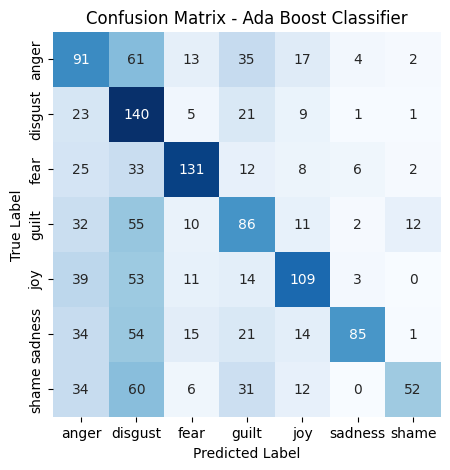

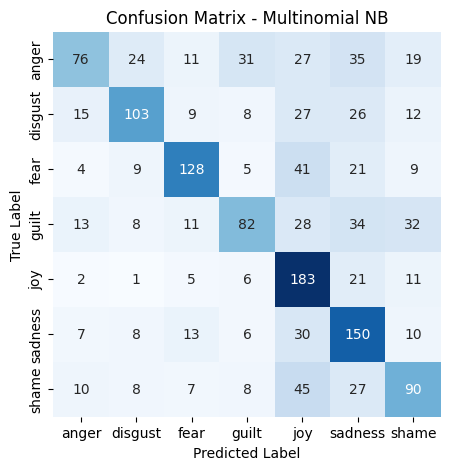

,Accuracy Score
Logistic Regression,0.586898
Random Forest Classifier,0.570187
Gradient Boosting Classifier,0.548128
Bernoulli NB,0.542781
Multinomial NB,0.542781
Decision Tree Classifier,0.474599
Ada Boost Classifier,0.463904


In [240]:
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer(ngram_range=(1,2))
classification_test(x,y,vect,confusion_mtr=True)

## <font color='#F27457'> Picking and Testing the Best Model

In [244]:
vect = CountVectorizer(ngram_range=(1,2))
l=LogisticRegression()
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
x_train_dtm = vect.fit_transform(x_train)
x_test_dtm = vect.transform(x_test)
model=l.fit(x_train_dtm, y_train)
predictions=model.predict(x_test_dtm)

In [245]:
accuracy_score(y_test, predictions)

0.5868983957219251

In [248]:
import joblib  

joblib.dump(model, 'logistic_regression_model.pkl')
joblib.dump(vect, 'vectorizer.pkl')

['vectorizer.pkl']

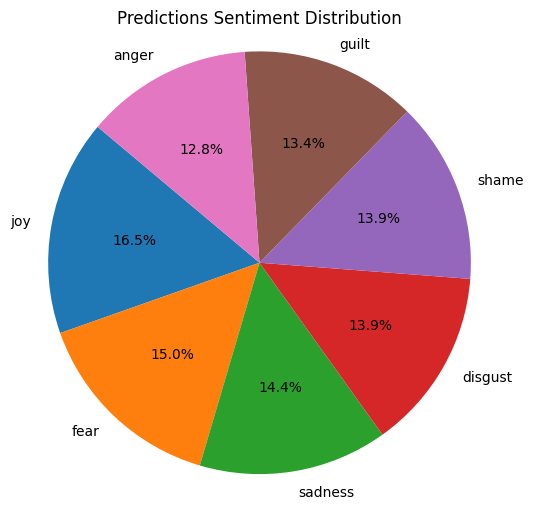

In [267]:
predictions_series = pd.Series(predictions)

predictions_counts = predictions_series.value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    predictions_counts, 
    labels=predictions_counts.index, 
    autopct='%1.1f%%', 
    startangle=140, 
)
plt.title('Predictions Sentiment Distribution')
plt.axis('equal')  
plt.show()

In [253]:
text=['This looks so impressive']
text=vect.transform(text)
model.predict(text)

array(['shame'], dtype=object)

In [255]:
text=['I have a fear of dogs']
text=vect.transform(text)
model.predict(text)

array(['fear'], dtype=object)

In [257]:
text=['My dog died yesterday']
text=vect.transform(text)
model.predict(text)

array(['sadness'], dtype=object)

In [265]:
text=[ "I don't love you anymore..! "]
text=vect.transform(text)
model.predict(text)

array(['joy'], dtype=object)

## <font color='#F27457'>Conclusion

This project successfully implemented various machine learning models to classify emotions from text data. After extensive experimentation with multiple algorithms, **Logistic Regression** achieved the highest accuracy of **58.69%**, as shown in the confusion matrix. The model performed relatively well in identifying distinct emotional categories, though there were some misclassifications, particularly between similar emotions such as guilt and shame.

Among the models tested, **Random Forest (57.02%)** and **Gradient Boosting (54.81%)** followed closely in performance, while **Naïve Bayes models (54.27%)** exhibited comparable results. However, traditional tree-based methods like **Decision Tree (47.46%)** and **AdaBoost (46.39%)** underperformed in comparison. 


Overall, this study demonstrates the feasibility of machine learning for emotion recognition and lays the groundwork for further advancements in sentiment analysis and affective computing.